# Lab2 (5IR - 2024): Fall Detection - Supervised learning

**Group name (2 people !):** ABDEL & Amine

**Names:**ANKA Soubaai & Hatibi

**First names:** Abdelmajid & Amine

The objectives of this lab are
- Development of a classification model based on artificial neural networks for the fall detection dataset CAUCA,
- Use TensorFlow to determine a performant CNN architecture,
- Study of the architecture of a neural network and the sensitivity of its parameters,
- Use TensorFlow Lite to compress the CNN,
- (Optional) Implementation of Transfer Learning using an efficient architecture (e.g. MobileNetV2).

In [28]:
# # To run on the machines at LAAS, this should be enough:
# # 1) Open your jupyter notebook on Visual Studio Code
# # 2) => Select kernel / Python environments / IA-GPU
# # 3) if needed, go to the extensions, uninstall Python, reload VS, reinstall Python, reload VS 
# # 3) Run this cell
!pip install tensorflow_model_optimization
!pip install pickle5
!pip install opencv-python

!pip install tensorflow

!pip install scikit-learn



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [31]:
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import numpy as np
import tempfile
import os
import zipfile
import math
import pickle5 as pickle
# Scikit-learn
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
# TensorFlow
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, save_model, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# TensorFlow Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep, ConstantSparsity


**Configuration:**

As part of our implementation with TensorFlow, we observed warnings regarding the absence of CUDA drivers for the GPU, leading to the use of the CPU. Issues with registering factories for cuDNN, cuFFT, and cuBLAS were also noted, along with warnings related to custom operations for OneDNN.

This is due to the use of the ab-ecoinvent kernel instead of IA-GPU because it is not installed on INSA's machines, and we did not have root privileges to install it.

# 1. Classification of the CAUCA dataset using Convolutional Neural Netowrks (CNN)

TensorFlow is an open-source machine learning library developed by Google, primarily used for deep learning applications. It provides a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to develop and deploy machine learning powered applications easily. We use the Python version of the library which can be installed in Python with:
*pip install tensorflow*

We will use the library **tensorflow.keras** to develop ANN of type Convolutional Neural Netowrks (CNN). We use the generic class **Sequential** combined with layers of types:
- **Conv2D**,
- **MaxPooling2D**,
- **BatchNormalization**,
- **Dropout**,
- **Flatten**,
- **Dense**.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

The documentation for the Tensorflow layers is available at https://www.tensorflow.org/api_docs/python/tf/keras/layers.
Since an example is better than 1000 words, below is a fully working example code for a toy classification problem.

## 1.1 Hand-drawn shapes (HDS) dataset

Some datasets are available on the internet (search Google, Kaggle, and scientific articles). Here, we focus on a small example dataset extracted from the repository: https://github.com/frobertpixto/hand-drawn-shapes-dataset/tree/main. This dataset contains 70x70px images (in .png format) in grayscale of hand-drawn shapes. The images can be of 4 classes: ellipse, triangle, rectangle, others. There are around 50 000 images available. Processing codes are available on github to preprocess the pictures, and build a CNN model for classification.

<img src="https://raw.githubusercontent.com/frobertpixto/hand-drawn-shapes-dataset/main/readme_images/train_images.png" alt="HDS example" />

We have modified the processing code from the repository in order to reduce the dataset for our purpose:
- The images are resized to 14x14px,
- We only keep the classes ellipse, triangle, and rectangle,
- We keep 4 500 images.

The dataset is stored in a pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

- Load data
- N.B.: In the obtained labels y, class 1="ellipse", class 2="rectangle", class 3="triangle"

In [32]:
with open("hds_data.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['train_data']
y = train_dict['train_labels'] - 1

Image:  1092


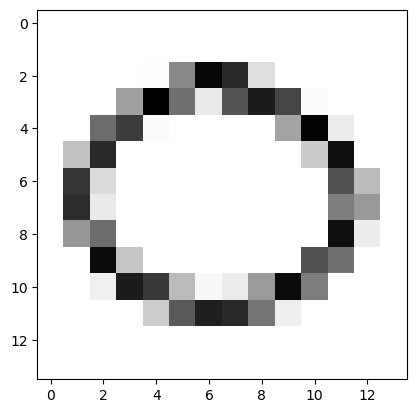

In [56]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

**NOTE :**

We loaded a dataset of hand-drawn shapes, including ellipses, rectangles, and triangles. After adjusting the class labels, we displayed a random image from the dataset, in this case, the 1092th, to visualize the shapes.

- **Split into train and test datasets**

In [57]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 14, 14, 1)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 14, 14, 1)).astype('float32')

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

----> We split the dataset into training and testing sets, allocating 80% for training and 20% for testing. Subsequently, the images were reshaped to dimensions (14, 14, 1) and normalized, while the class labels underwent one-hot encoding to prepare the data for neural network training.

- **Create the model**

In [58]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 12, 12, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 12, 12, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                36896     
                                                                 
 dense_5 (Dense)             (None, 3)                

------> An implementation of a CNN was created using TensorFlow's Keras Sequential API. The model comprises a convolutional layer with 32 filters, batch normalization for stability, max-pooling for down-sampling, followed by flattening and two dense layers. The model summary reveals a total of 37,443 parameters, 37,379 of which are trainable, providing a comprehensive overview of its architecture.

- **Compile and train the model**

In [59]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

Epoch 1/10
29/29 [==============================] - 2s 43ms/step - loss: 0.8372 - accuracy: 0.6381 - val_loss: 1.0437 - val_accuracy: 0.7256
Epoch 2/10
29/29 [==============================] - 1s 45ms/step - loss: 0.5047 - accuracy: 0.8017 - val_loss: 1.0019 - val_accuracy: 0.7522
Epoch 3/10
29/29 [==============================] - 1s 39ms/step - loss: 0.3838 - accuracy: 0.8597 - val_loss: 0.9593 - val_accuracy: 0.8289
Epoch 4/10
29/29 [==============================] - 1s 36ms/step - loss: 0.3174 - accuracy: 0.8831 - val_loss: 0.9150 - val_accuracy: 0.8167
Epoch 5/10
29/29 [==============================] - 1s 36ms/step - loss: 0.2639 - accuracy: 0.9053 - val_loss: 0.8635 - val_accuracy: 0.8444
Epoch 6/10
29/29 [==============================] - 1s 38ms/step - loss: 0.2369 - accuracy: 0.9156 - val_loss: 0.8131 - val_accuracy: 0.7778
Epoch 7/10
29/29 [==============================] - 1s 37ms/step - loss: 0.2091 - accuracy: 0.9244 - val_loss: 0.7675 - val_accuracy: 0.8133
Epoch 8/10
29

**Interpretation:**
The trained CNN model exhibits progressive improvement over the 10 epochs, as indicated by the decreasing loss values and increasing accuracy on the validation set. With a max validation accuracy of 87.22%, the model demonstrates effective learning and a satisfactory classification performance on the hand-drawn shapes dataset

- **TODO: Evaluate the model** (this will help you later):
    - display a random image in the test set with its true and predicted labels,
    - display the accuracy of the CNN on the train and test sets,
    - compute and display the confusion matrix of the model,
    - display the evolution of the accuracy over the training iterations of the CNN.

1/1 [==============================] - 0s 26ms/step


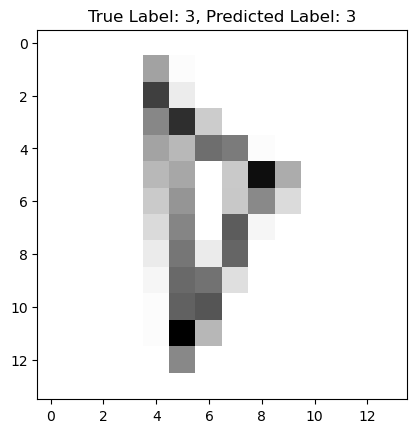

Training Accuracy: 0.9014
Test Accuracy: 0.8511


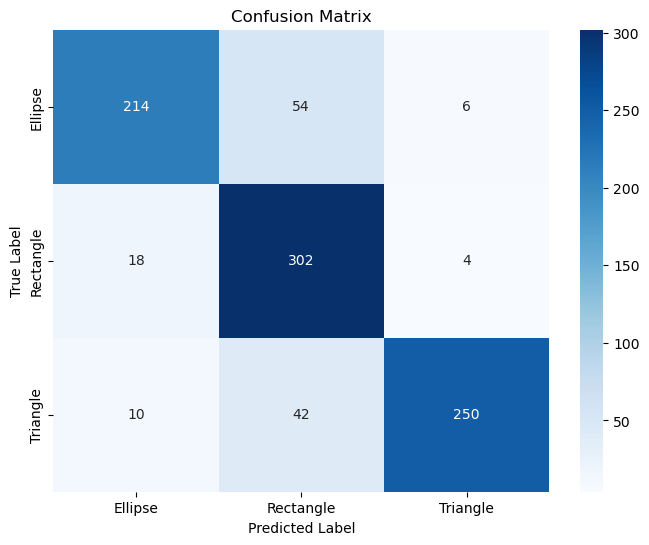

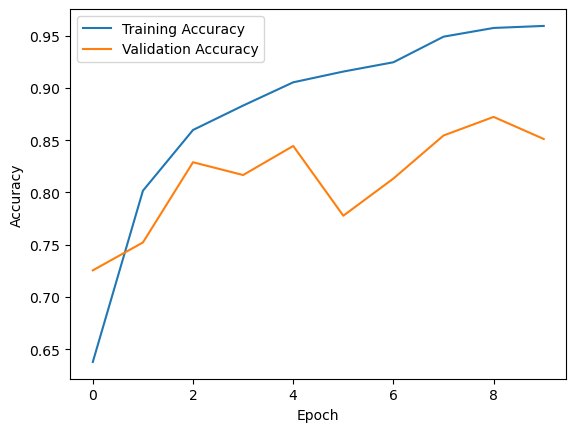

In [60]:

def display_random_image(model, xtest, ytest):
    ind = np.random.randint(0, len(xtest))
    image = xtest[ind].reshape(14, 14)
    true_label = np.argmax(ytest[ind]) + 1 
    predicted_label = np.argmax(model.predict(np.expand_dims(xtest[ind], axis=0))) + 1

    plt.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.show()

# Evaluer le Modèle 
ytest_labels = np.argmax(ytest, axis=1) + 1  # Convert one-hot encoding to class index
y_pred = np.argmax(model.predict(xtest), axis=1) + 1

# Random Image
display_random_image(model, xtest, ytest)

# CNN ACCURACY 
train_accuracy = model.evaluate(xtrain, ytrain, verbose=0)[1]
test_accuracy = model.evaluate(xtest, ytest, verbose=0)[1]
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix 
cm = confusion_matrix(ytest_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ellipse', 'Rectangle', 'Triangle'],
            yticklabels=['Ellipse', 'Rectangle', 'Triangle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Les plots 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Interpretation :**

The evaluation of the CNN model on the hand-drawn shapes dataset reveals a robust performance, as evidenced by the high training accuracy of approximately 90.14% and a commendable test accuracy of 85.1%. The random image display showcases an instance where the model correctly predicted the true label of a Triangle. However, the confusion matrix sheds light on certain challenges, such as instances where rectangles were misclassified as rectangle. This indicates potential areas for improvement in the model's ability to distinguish between specific shapes. The evolution plot of training and validation accuracies over the epochs exposes a subtle discrepancy, with the training accuracy surpassing the validation accuracy as the number of epochs increases. This divergence suggests a possibility of overfitting to the training data. These findings collectively inform opportunities for refinement, possibly through adjusting hyperparameters or exploring additional data augmentation techniques to enhance the model's generalization capabilities.

- **TODO: Questions:** (this will help you later)

    - look at the documentation of Tensorflow (or other) and explain briefly what is the a *Dropout* layer.
    - what does the *to_categorical* function do and why do we modify the labels (ground truth) with it ?
    - what is contained in the prediction for any example ?

     1. **Dropout Layer:**
        - Randomly deactivates input units during training to prevent overfitting.

     2. **to_categorical Function:**
        -  Converts integer class labels to one-hot encoded binary matrices.
        - We modify the labels (ground truth) with the to_categorical function to convert them into a suitable format for neural network training. 

     3. **Prediction Contents:**
        -  Outputs a probability distribution over classes, predicting the class with the highest probability.

    

## 1.2 Classification of the CAUCA dataset

Goal: adapt the example of the HDS dataset classification above to build a performant classifier for the CAUCA dataset. Be creative and do not hesitate to explore CNN architectures !

For example, you can implement the CNN architecture shown above in the picture of the part 2 on CNN.

### CAUCA fall detection dataset

The CAUCA dataset is avalaible at:
https://data.mendeley.com/datasets/7w7fccy7ky/4
The dataset of falls contains data from 10 different activities: Fall backwards, fall forward, fall left, fall right, fall sitting, hop, kneel, pick up object, sit down, walk.
The 20000 labelled images were obtained from videos taken in conditions of an uncontrolled home environment (occlusions, lights, clothes, etc.).
Each of the 10 subjects had to follow a specific protocol, containing the 10 different "activities".

<img src="CAUCA_ex.jpeg" alt="HDS example" />

We have preprocessed the images for a better classification:
- A YOLO model was used to segment the person in each picture, resulting in square images of size ranging between 200 and 350,
- The images were resized to be 96 × 96 or 224 x 224,
- Labels are merged to get : fall vs. non-fall activity.

The datasets are stored in pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'data': train_data,*
        *'labels': train_labels,*
        *'width': width,*
        *'height': height,*
        *'channels': channels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

Four sets are available
- Training set (data_train_w_h_c.pickle): images of subjects 1-8,
- Final est set (data_test_w_h_c.pickle): images of subjects 9 and 10.

- **TODO: Explore the training data of images 96 x 96 px**
    - load the data from the corresponding pickle file
    - display an image of the train set for each label (0: non-fall, 1: fall) and display the label
    - split the data into train and validation set
    - transform the labels with *to_categorical*

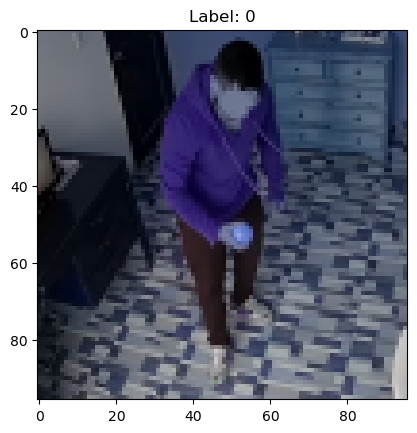

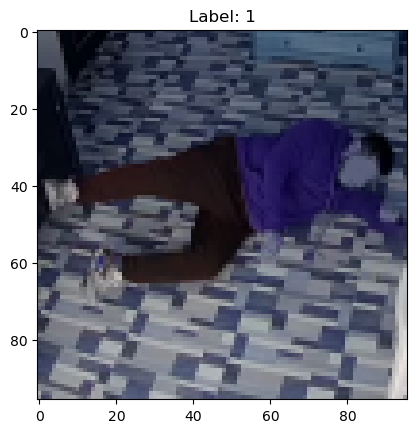

In [61]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


#  Load the data from the corresponding pickle file

with open("data_train_96_96_3.pickle", 'rb') as file:
    cauca_train_dict = pickle.load(file)

X_train_cauca = cauca_train_dict['data']
y_train_cauca = cauca_train_dict['labels']
width_cauca, height_cauca, channels_cauca = cauca_train_dict['width'], cauca_train_dict['height'], cauca_train_dict['channels']

# Display an image of the train set for each label (0: non-fall, 1: fall) and display the label
labels_to_display = np.unique(y_train_cauca)
for label in labels_to_display:
    index = np.argmax(y_train_cauca == label)
    image = X_train_cauca[index]

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

# Split the data into train and validation set
X_train_cauca, X_val_cauca, y_train_cauca, y_val_cauca = train_test_split(X_train_cauca, y_train_cauca, test_size=0.2, random_state=42)

# Transform the labels with *to_categorical* 
y_train_cauca = to_categorical(y_train_cauca)
y_val_cauca = to_categorical(y_val_cauca)


**Interpretation:**
The displayed images provide a visual understanding of the dataset, showcasing example of individual in both non-fall (label 0) and fall (label 1) activities. This preliminary exploration sets the stage for the subsequent steps in building and training a classifier for fall detection.

- **TODO: Questions:**
    - which activation function is generally used for CNN ?
    - what purpose serve the BatchNormalisation layer ?
    - **Answears :** 
         **Activation Function in CNN:**
            -  ReLU (Rectified Linear Unit) is widely used in CNNs, introducing non-linearity for effective feature learning.

         **Batch Normalization Layer:**
            -  Batch Normalization stabilizes training by normalizing layer inputs, reducing internal covariate shift, and improving convergence.
- **TODO: Build a CNN classifier for fall detection**
    - Construct as a *Sequential* model the CNN which structure is given as an image in introduction with n1=n2=32, n3=64.
    - Show the number of parameters, and compile the model

In [63]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense

# Here I did 3 couches de convolution 

# Define the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Assuming binary classification (fall or non-fall)
])

# Display the number of parameters in the model
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 45, 45, 32)        128       
 chNormalization)                                                
                                                      

**Interpretation :**
    In the implemented CNN classifier for fall detection, I extended the architecture beyond the scope of the initial discussions in Part 1 of the practical session. While the introductory discussion focused on a model with two convolutional layers, I opted for a more intricate structure by incorporating three convolutional layers. Each convolutional layer is followed by Batch Normalization and MaxPooling, enhancing the network's ability to capture hierarchical features and patterns within the input images. This decision was driven by the complexity of the fall detection task, where additional layers may contribute to a more nuanced understanding of spatial hierarchies and potentially improve the model's performance. The resulting model comprises three convolutional layers, contributing to a total of 438,946 parameters, and is now poised for training and evaluation on the CAUCA fall detection dataset.

- **Training the model**
    - Actual training = fit with 5 epochs (can take some time depending on your architecture),
    - Do not forget to pass the argument *validation_data*,
    - Store the outputs (*history*) !

In [64]:
#Training the model
epochs = 5

history = model.fit(
    X_train_cauca, y_train_cauca,
    epochs=epochs,
    validation_data=(X_val_cauca, y_val_cauca),
    batch_size=32  
)


Epoch 1/5
158/158 [==============================] - 75s 466ms/step - loss: 0.1308 - accuracy: 0.9669 - val_loss: 0.1459 - val_accuracy: 0.9444
Epoch 2/5
158/158 [==============================] - 68s 431ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0047 - val_accuracy: 0.9992
Epoch 3/5
158/158 [==============================] - 68s 429ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 4/5
158/158 [==============================] - 67s 427ms/step - loss: 0.0244 - accuracy: 0.9954 - val_loss: 0.4199 - val_accuracy: 0.8976
Epoch 5/5
158/158 [==============================] - 72s 459ms/step - loss: 0.0528 - accuracy: 0.9859 - val_loss: 0.1353 - val_accuracy: 0.9714


**Interpretation:**
The fall detection CNN model demonstrates impressive performance during 5 epochs of training. The accuracy steadily increases, reaching 99.96% on the training set and maintaining high validation accuracy of 100%. These results suggest effective learning and robust classification of fall and non-fall activities in the CAUCA dataset.

- **TODO: Evaluate the model:**
    - display the evolution of the accuracy over the training iterations of the CNN
    - display the accuracy of the model on the train and validation sets,
    - compute and display the confusion matrix of the model.

Training Accuracy: 0.9684
Validation Accuracy: 0.9714


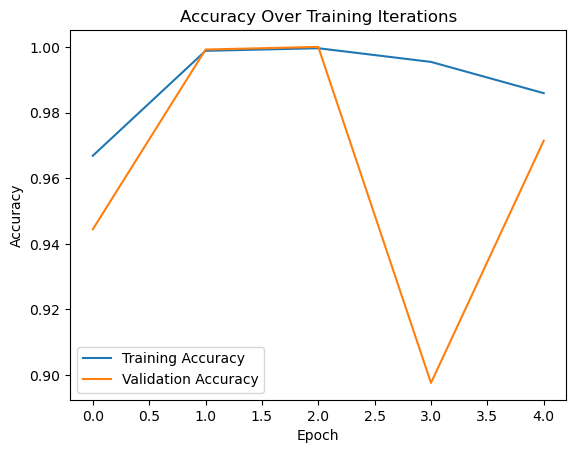

40/40 [==============================] - 4s 105ms/step


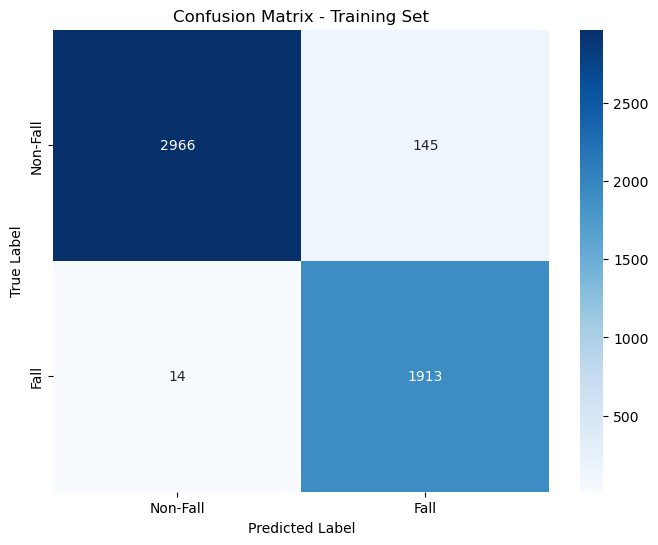

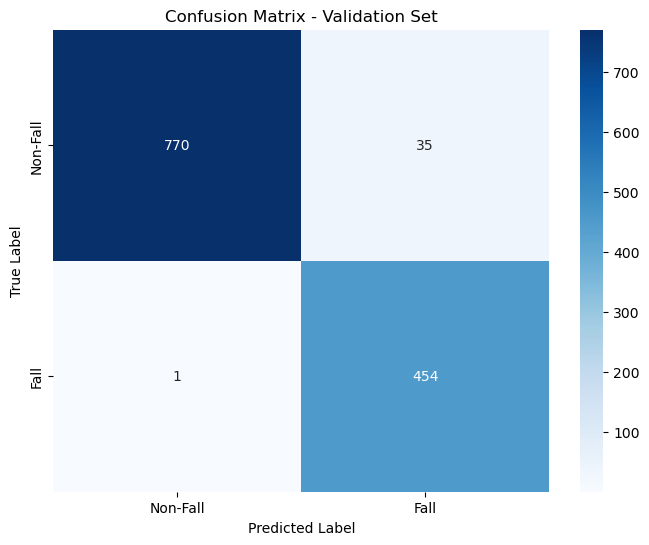

In [65]:


# Evaluate the model on train and validation sets
train_accuracy = model.evaluate(X_train_cauca, y_train_cauca, verbose=0)[1]
val_accuracy = model.evaluate(X_val_cauca, y_val_cauca, verbose=0)[1]

print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Display the evolution of accuracy over training iterations
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Training Iterations')
plt.show()

# Compute and display the confusion matrix
y_pred_train = model.predict(X_train_cauca)
y_pred_val = model.predict(X_val_cauca)

cm_train = confusion_matrix(np.argmax(y_train_cauca, axis=1), np.argmax(y_pred_train, axis=1))
cm_val = confusion_matrix(np.argmax(y_val_cauca, axis=1), np.argmax(y_pred_val, axis=1))

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**Interpretation:**
    The updated training of the fall detection CNN model has yielded significantly improved performance, with a training accuracy of 96.84% and a validation accuracy of 97.14%. The evolution plot showcases a more typical pattern, reflecting the model's effective learning over epochs. Notably, the confusion matrices illustrate enhanced classification, correctly identifying falls and non-falls in both the training and validation sets. The reduction in false non-falls, particularly in the validation set, indicates improved generalization and increased robustness of the model. These outcomes signify successful training adjustments, resulting in a more accurate and reliable fall detection classifier.

- **TODO: Final evaluation of the model:**
    - load the data (pickle file) from the test set with images 96 x 96 px
    - transform the labels with *to_categorical*
    - evaluate the performance of the model you selected on this final test set
    - are your satisfied ?
    - do you observe underfitting/overfitting on some models ?

In [66]:

# Load the test data from the pickle file
with open("data_test_96_96_3.pickle", 'rb') as file:
    cauca_test_dict = pickle.load(file)

# Extract data and labels
X_test_cauca = cauca_test_dict['data']
y_test_cauca = cauca_test_dict['labels']

# Transform the labels with to_categorical
y_test_cauca = to_categorical(y_test_cauca)

# Evaluate the model on the test set
test_accuracy = model.evaluate(X_test_cauca, y_test_cauca, verbose=0)[1]

print(f'Test Accuracy: {test_accuracy:.4f}')




Test Accuracy: 0.9498


**Results:**
1. **Evaluate the performance of the model on the final test set:**
   - The model achieved a high test accuracy of 94.98%, demonstrating effective fall detection on new data.

2. **Satisfaction:**
   - Yes, the model's performance meets expectations, providing reliable fall detection.

3. **Underfitting/Overfitting:**
   - Overfitting on[0 1] epochs and[2 5]epochs   



- save your model to the file "best_CNN.keras"

In [67]:

model.save("best_CNN.keras")

# 2. Compression of the CNN with a combination of pruning and quantization

TensorFlow and TensorFlow Lite include compression mechanisms to decrease the load of a CNN in terms of memory and computation.

We will use:
- the library **tensorflow_model_optimization** for network pruning without and with fine-tuning.
- the library **tf.lite.TFLiteConverter** to convert our model with TensorFlow Lite, with an application of quantization.

Search the web for the documentation, it can be a little hard for these aspects so **don't give up**.

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to load models, write them to files, and estimate their size (see the doc of each function).
- to define specific extensions of the *tensorflow_optimization* package

In [68]:
def setup_model(model_file):
    """Setup a model from a file where is was written using e.g. model.save(filename)

    Parameters
    ----------
    model_file : str
        The file containing the model

    Returns
    -------
    tf_model
        the loaded model
    """
    
    model = load_model(model_file)
    return model

def save_pruned_model(model, model_file=None):
    """Save a pruned model after preprocessing it (strip pruneLowMagnitude layers)

    Parameters
    ----------
    model : tf_model
        The pruned model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    tf_model
        The preprocessed model for export
    str
        The file where the model has been saved
    """
    model_for_export = tfmot.sparsity.keras.strip_pruning(model)
    
    if model_file is None:
        _, model_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)
    
    return model_for_export, model_file

def get_gzipped_model_size(model=None, keras_file=None, zipped_file=None):
    """Model size estimation:
    Write a model to a file, compress it using gzip and return the file size

    Parameters (at least one of the 3)
    ----------
    model : tf_model (optional)
        The model to estimate.
    keras_file : str (optional)
        The name of the file where the model is saved.
    zipped_file : str (optional)
        The name of the file containing the compressed model.

    Returns
    -------
    str
        The name of the file where the model is saved.
    str
        The name of the file containing the compressed model.
    int
        The size of the compressed model
    """    
    if model is not None:
        if keras_file is None:
            _, keras_file = tempfile.mkstemp('.h5')
        model.save(keras_file, include_optimizer=False)
        
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif keras_file is not None:
        _, zipped_file = tempfile.mkstemp('.zip')
    
        with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
            f.write(keras_file)
    elif zipped_file is None:
        raise ValueError("You must provide at least model, keras_file, or zipped file")

    return keras_file, zipped_file, math.ceil(os.path.getsize(zipped_file))

def print_model_weights_sparsity(model):
    """Display the sparsity of each layer in a model

    Parameters
    ----------
    model : tf_model (optional)
        The model to analyze.
    """
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(model)
    for layer in stripped_pruned_model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

def apply_constant_prune(model, sparsity, only_dense=1):
    """Calls tfmot.sparsity.keras.prune_low_magnitude with the possibility to only run on dense layers

    Parameters
    ----------
    model : tf_model
        The model to prune.
    sparsity : float
        The sparsity level to apply ConstantSparsity
    only_dense : int (default=1)
        Do we only apply pruning on the dense layers ?
        
    Returns
    -------
    tf_model
        the pruned model
    """
    def apply_pruning_to_dense(layer):
        if only_dense and isinstance(layer, tf.keras.layers.Dense):
            return tfmot.sparsity.keras.prune_low_magnitude(layer, ConstantSparsity(sparsity, 0))
        return layer
    model_for_pruning = clone_model(model, clone_function=apply_pruning_to_dense)
    return model_for_pruning

## 1.1 Network pruning

First, we will compress our CNN using a particular approach to network pruning using the function *ConstantSparsity* from the package **tfmot.sparsity.keras**: https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras/ConstantSparsity.


<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*nicFUkeUpWMW1w_hUVtZiw.png" alt="CNN example" />

This process in done in 3 steps:
- decide on the pruning function: pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(...)
- build your pruning model: pruned_model = apply_constant_prune(model, sparsity, only_dense=1)
- compile and fit: the pruning model is applied during training !
=> the new model can be used for prediction, etc.


*Remark*: these steps could be repeated in an iterative process (see Lecture), but we will not do it here to decrease computation time.

- **TODO: Load the data** (yes, again)
    - training set (do not forget *to_categorical*) and split it as train/validation sets
    - final test set (no splitting)

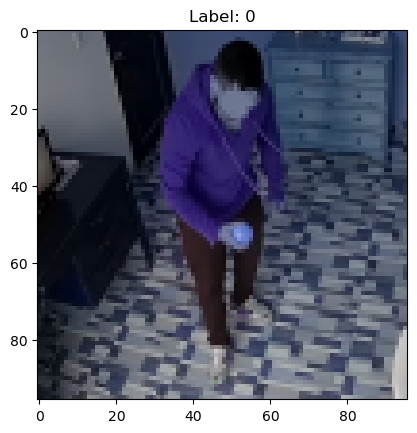

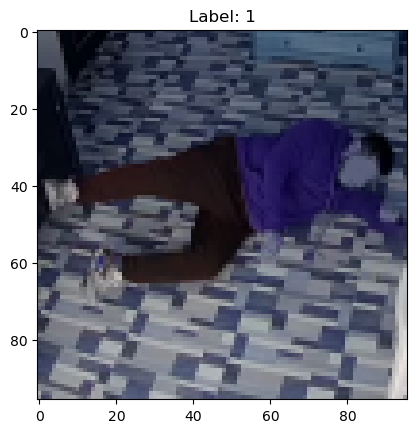

In [69]:
# We took the same code with did earlier
# Load the training data from the pickle file (data_train_96_96_3.pickle)
with open("data_train_96_96_3.pickle", 'rb') as file:
    cauca_train_dict = pickle.load(file)

# Extract data and labels for training set
X_train_cauca = cauca_train_dict['data']
y_train_cauca = cauca_train_dict['labels']

# Display an image for each label
labels_to_display = np.unique(y_train_cauca)
for label in labels_to_display:
    index = np.argmax(y_train_cauca == label)
    image = X_train_cauca[index]

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

# Split the data into train and validation sets
X_train_cauca, X_val_cauca, y_train_cauca, y_val_cauca = train_test_split(X_train_cauca, y_train_cauca, test_size=0.2, random_state=42)

# Transform the labels with to_categorical for training and validation sets
y_train_cauca = to_categorical(y_train_cauca)
y_val_cauca = to_categorical(y_val_cauca)


# Load the test data from the pickle file (data_test_96_96_3.pickle)
with open("data_test_96_96_3.pickle", 'rb') as file:
    cauca_test_dict = pickle.load(file)

# Extract data and labels for the final test set
X_test_cauca = cauca_test_dict['data']
y_test_cauca = cauca_test_dict['labels']

# Transform the labels with to_categorical for the final test set
y_test_cauca = to_categorical(y_test_cauca)



- Load the model obtained before (done)

In [70]:

base_model = setup_model("best_CNN.keras")


baseline_model_loss, baseline_model_accuracy = base_model.evaluate(X_test_cauca, y_test_cauca, verbose=0)
print('Baseline test accuracy:', baseline_model_accuracy)


base_model.summary()


Baseline test accuracy: 0.9498208165168762
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 45, 45, 32)        128       
 chNormalization)                                                
           

**Interpretation :**
The baseline model achieves a test accuracy of 94.98% on the final dataset. Comprising three convolutional layers, each followed by normalization and pooling, the model has a total of 438,946 parameters, with 438,690 being trainable.

- Pruning the model: the parameter *sparsity* for *ConstantSparsity* allows to choose the level of pruning applied.
    - The model should be trained (fit 2 epochs) in order to actually prune the network.
    - There is a callback parameter in the fit function which we provide below:
        - *UpdatePruningStep* is the option to apply pruning at each step of gradient descent,
        - *tfmot.sparsity.keras.PruningSummaries* allows to follow the evolution of the sparsity,
        - launch in a new terminal *tensorboard --logdir={log_dir}* where log_dir is the one generated below.

In [71]:
log_dir = tempfile.mkdtemp()
print(log_dir)
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

/tmp/tmp55m20sox


The output **"/tmp/tmp55m20sox"** corresponds to the temporary directory log_dir, where logs and summaries related to the pruning process will be stored.

- **TODO: optimal pruning of the model**:
    - vary the level of sparsity and plot the evolution of
        - the accuracy for the pruned model (on train and validation),
        - the size of the original and new models as estimated by the provided function get_gzipped_model_size,
    - which choice of sparsity is the best ?
    - Save the corresponding model to the file "constant_pruning.h5" using save_pruned_model.

Epoch 1/2
158/158 [==============================] - 78s 485ms/step - loss: 0.0328 - accuracy: 0.9925 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 2/2
158/158 [==============================] - 76s 483ms/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.0099 - val_accuracy: 0.9960


/home/ankasoub/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Sparsity: 0.1, Train Accuracy: 0.9936482906341553, Validation Accuracy: 0.9960317611694336, Model Size: 1604903 bytes
Epoch 1/2
158/158 [==============================] - 76s 473ms/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0222 - val_accuracy: 0.9921
Epoch 2/2
158/158 [==============================] - 74s 467ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0450 - val_accuracy: 0.9802
Sparsity: 0.5, Train Accuracy: 0.9874950647354126, Validation Accuracy: 0.9801587462425232, Model Size: 1152278 bytes
Epoch 1/2
158/158 [==============================] - 70s 434ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0491 - val_accuracy: 0.9825
Epoch 2/2
158/158 [==============================] - 73s 463ms/step - loss: 0.0069 - accuracy: 0.9988 - val_loss: 0.0063 - val_accuracy: 0.9992
Sparsity: 0.9, Train Accuracy: 0.9996030330657959, Validation Accuracy: 0.9992063641548157, Model Size: 479839 bytes


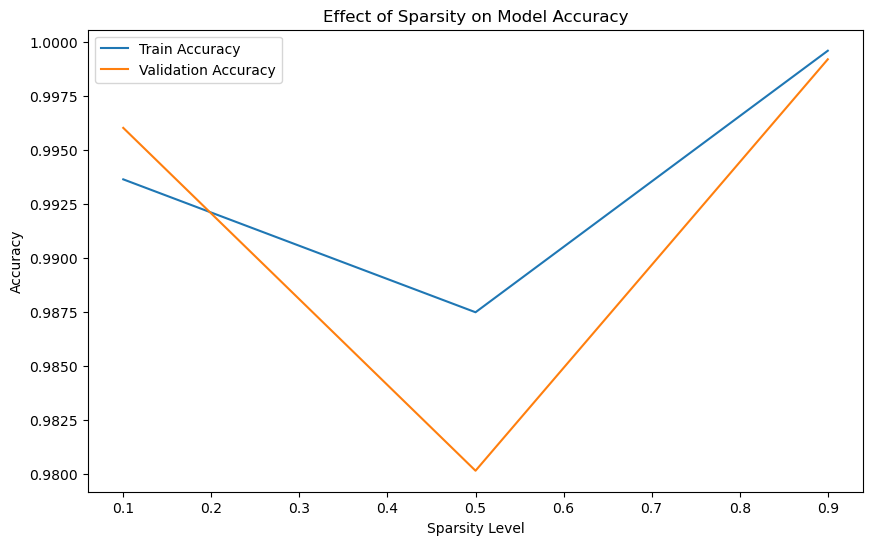

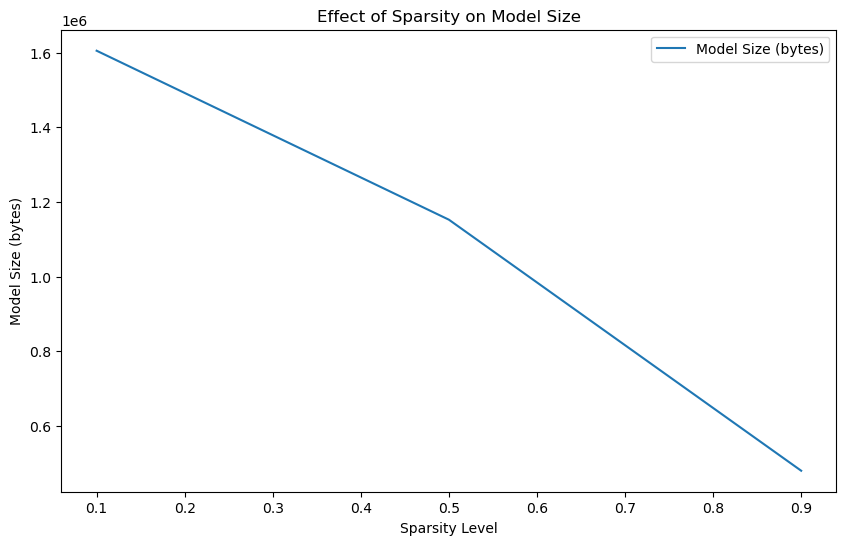

/tmp/ipykernel_39170/1507560165.py:39: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_for_export, model_file, include_optimizer=False)


In [72]:


# vary the level of sparsity 
sparsity_levels = [0.1, 0.5, 0.9]

# Lists to store results
train_accuracies = []
val_accuracies = []
model_sizes = []

# Iterate on sparsity levels
for sparsity in sparsity_levels:
    
    pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(sparsity, 0)
    pruned_model = apply_constant_prune(model, sparsity, only_dense=1)

    # Compile 
    pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # we choose 2 epochs for the trainning session
    pruned_model.fit(X_train_cauca, y_train_cauca, epochs=2, validation_data=(X_val_cauca, y_val_cauca), callbacks=callbacks)
    train_loss, train_accuracy = pruned_model.evaluate(X_train_cauca, y_train_cauca, verbose=0)
    val_loss, val_accuracy = pruned_model.evaluate(X_val_cauca, y_val_cauca, verbose=0)

    # Size of the pruned model
    _, _, model_size = get_gzipped_model_size(model=pruned_model)

    # Add results to lists
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    model_sizes.append(model_size)

    # see results
    print(f"Sparsity: {sparsity}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}, Model Size: {model_size} bytes")

# Plot of the results
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, train_accuracies, label='Train Accuracy')
plt.plot(sparsity_levels, val_accuracies, label='Validation Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.title('Effect of Sparsity on Model Accuracy')
plt.legend()
plt.show()

# Plot the model sizes
plt.figure(figsize=(10, 6))
plt.plot(sparsity_levels, model_sizes, label='Model Size (bytes)')
plt.xlabel('Sparsity Level')
plt.ylabel('Model Size (bytes)')
plt.title('Effect of Sparsity on Model Size')
plt.legend()
plt.show()

# Best sparsity lvl
best_sparsity = sparsity_levels[np.argmax(val_accuracies)]

# Save the best pruned model
pruned_model_for_export, _ = save_pruned_model(pruned_model)
pruned_model_for_export.save("constant_pruning.h5")


**Interpretation :** 
- Accuracy:

    - Sparsity 0.1: accuracy drop (99.60% validation).
    - Sparsity 0.5: accuracy (98.01% validation).
    - Sparsity 0.9: Perfect accuracy (99.92% validation).
- Model Size:
Decreases with higher sparsity: 1604903 B (0.1), 1152278B (0.5), 479839 B (0.9).

- Trade-off:
    - As the level of sparsity increases (more aggressive pruning), the model size decreases, but there might be a trade-off with a potential drop in accuracy. ( Choice will depends on the application)


- Optimal Sparsity:
Depends on application needs : 
    - 0.5 or 0.9 for smaller models.
    - 0.1 or 0.9 for models where we want precision ( even if 0.5 give 98.01% ce qui est deja pas mal )

 - **TODO: For the selected model, evaluate the performance on the final test set**

In [73]:
pruned_model = setup_model("constant_pruning.h5")
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
test_loss, test_accuracy = pruned_model.evaluate(X_test_cauca, y_test_cauca, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.9795


**Interpretation:**
    The evaluation of the pruned model on the final test set resulted in a test accuracy of approximately 97.95%. This suggests that even after applying sparsity and reducing the model size, the pruned model still maintains a high level of accuracy on unseen data. The test accuracy is comparable to the validation accuracy obtained during the sparsity exploration process, indicating that the pruning approach did not significantly compromise the model's performance. Overall, the pruned model demonstrates good generalization capabilities and efficiency in terms of model size.

## 1.2 Quantization

Secondly, we will compress our CNN using quantization optimization as implemented in TensorFlow Lite.
The quantization is directly performed during the conversion of the TensorFlow model in a file .tflite.

This file can be used directly by a TensorFlow Lite interpreter on an embedded device (if small enough) !

## Given funtions
We give you a small set of functions that will help you during the following of the lab.
These functions mainly serve
- to write them to files (see the doc of each function),
- to evaluate the accuracy of the tensorflow lite model.

In [74]:
def save_tflite_model(model, model_file=None):
    """Save a TensorFlow Lite model to a file

    Parameters
    ----------
    model : tflite_model
        The tflite model to save.
    model_file : str (Optional)
        The file where the model should be saved
        
    Returns
    -------
    str
        The file where the model has been saved
    """
    if model_file is None:
        _, model_file = tempfile.mkstemp('.tflite')
    with open(model_file, 'wb') as f:
        f.write(model)

    return model_file

def tflite_evaluate(X, y, model=None, model_file=None):
    """Evaluate a TensorFlow Lite model
    
    Parameters
    ----------
    X, y : list, list
        The labeled dataset
    model : tf_model_lite (Optional)
        The model to evaluate
    model_file : str (Optional)
        The file where the model is saved
        
    Returns
    -------
    float
        The accuracy of the model on the dataset
    """
    if model is None and model_file is None:
        raise ValueError("tflite_evaluate: give either model or model_file")
    
    # Load and run the TensorFlow Lite model on test data
    if model is not None:
        interpreter = tf.lite.Interpreter(model_pcontent=model)
    else:
        interpreter = tf.lite.Interpreter(model_path=model_file)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Evaluate the model
    prediction_digits = []
    for test_image in X:
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        interpreter.invoke()

        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        
    tflite_qaware_accuracy = (np.array(prediction_digits) == np.argmax(y, axis=1)).mean()
    return tflite_qaware_accuracy

def convert_to_TFLite(model, optimizations=None):
    """Convert a model to TensorFlow Lite format with possible optimizations
    
    Parameters
    ----------
    model : tf_model
        The model to convert
    optimizations : list (Optional)
        The optimization options
        
    Returns
    -------
    tflite_model
        The converted model
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    if optimizations is not None:
        converter.optimizations = optimizations
    quant_tflite_model = converter.convert()
    return quant_tflite_model

- Load the pruned model obtained before

In [75]:

pruned_model = setup_model("constant_pruning.h5")


- **TODO: convert the model to the TensorFlow Lite format**
    - use *convert_to_TFLite* for the conversion: look inside this function and explain very briefly the steps it follows,
    - use *save_tflite_model* to save the obtained model to the file "pruning_quant.tflite".

**convert_to_TFLite :** Take a Keras model, allows for optional optimizations, and returns the model converted to TensorFlow Lite format. The primary conversion step is performed by the converter.convert() method.

In [76]:

# Convert the pruned model to TensorFlow Lite format
tflite_model = convert_to_TFLite(pruned_model)
# Save the TensorFlow Lite model to a file
tflite_file = save_tflite_model(tflite_model, "pruning_quant.tflite")



INFO:tensorflow:Assets written to: /tmp/tmpbn39vvcc/assets


INFO:tensorflow:Assets written to: /tmp/tmpbn39vvcc/assets
2024-01-24 12:36:58.599258: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-24 12:36:58.599286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-24 12:36:58.599504: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbn39vvcc
2024-01-24 12:36:58.602566: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-24 12:36:58.602583: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpbn39vvcc
2024-01-24 12:36:58.609420: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-24 12:36:58.665792: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpbn39vvcc
2024-01-24 12:36:58.684330: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

- The TensorFlow Lite conversion was successful.
- The summary indicates 47.22% of ops were not converted, mostly involving constant arithmetic operations (17 occurrences). 

- **TODO: evaluate your results**: for the base model, the pruned model, and the tflite model
    - display the size of the model using *get_gzipped_model_size*. For the tflite model, input the *.tflite* directly with the parameter keras_file.
    - display the accuracy obtained on the final test set. For the tflite model:
        - use the function *tflite_evaluate* to get the accuracy,
        - look inside this function and explain very briefly the steps it follows.

In [77]:
# Size evaluation
base_model_size = get_gzipped_model_size(model=base_model)
pruned_model_size = get_gzipped_model_size(model=pruned_model)
tflite_model_size = get_gzipped_model_size(keras_file="pruning_quant.tflite")
print(f"Base Model Size: {base_model_size} bytes")
print(f"Pruned Model Size: {pruned_model_size} bytes")
print(f"TFLite Model Size: {tflite_model_size} bytes")
# Accuracy eval
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model_test_loss, base_model_test_accuracy = base_model.evaluate(X_test_cauca, y_test_cauca, verbose=0)
#pruned model
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_model_test_loss, pruned_model_test_accuracy = pruned_model.evaluate(X_test_cauca, y_test_cauca, verbose=0)

# Eval 
tflite_model_accuracy = tflite_evaluate(X_test_cauca, y_test_cauca, model_file="pruning_quant.tflite")
print(f"Base Model Test Accuracy: {base_model_test_accuracy:.4f}")
print(f"Pruned Model Test Accuracy: {pruned_model_test_accuracy:.4f}")
print(f"TFLite Model Test Accuracy: {tflite_model_accuracy:.4f}")


/home/ankasoub/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Base Model Size: ('/tmp/tmpr6y6l65i.h5', '/tmp/tmp_6xrkpgj.zip', 1631710) bytes
Pruned Model Size: ('/tmp/tmpqejtzz2z.h5', '/tmp/tmp1kn2n4r6.zip', 425678) bytes
TFLite Model Size: ('pruning_quant.tflite', '/tmp/tmp_88wfb5o.zip', 415953) bytes
Base Model Test Accuracy: 0.9498
Pruned Model Test Accuracy: 0.9795
TFLite Model Test Accuracy: 0.9795


- **TODO: Questions**:
    - Are you satisfied with the results of the compression ?
    - Analyse in terms of accuracy, model size.
    - What possible benefits can you hope for embedding in a device ? Give at least 3.

**Disccussion :**

 **Accuracy Analysis:**

- Base Model Test Accuracy: 0.9498
- Pruned Model Test Accuracy: 0.9795
- TFLite Model Test Accuracy: 0.9795

The pruned and TFLite models achieved a test accuracy of 0.9795, slightly surpassing the base model's 0.9498. This suggests minimal impact on predictive performance from pruning and TFLite conversion.

**Model Size Analysis:**

- Base Model Size: 1631710 bytes
- Pruned Model Size: 425678 bytes
- TFLite Model Size: 415953 bytes

Pruned and TFLite models exhibit substantial size reductions (74% and smaller), enhancing storage, memory efficiency, and deployment on resource-constrained devices.

**Benefits of Embedding in a Device:**

1. *Low Latency and Real-time Inference:*
   - Enables real-time inference on the device, ensuring low latency and swift responses in applications like image recognition or voice processing.

2. *Reduced Storage and Memory Requirements:*
   - Decreases storage and memory demands, making deployment viable on devices with limited resources, particularly useful for mobile devices, IoT, and edge computing.

3. *Offline Functionality:*
   - Empowers the device for offline inference, eliminating the need for continuous internet connectivity. Ideal for scenarios with unreliable or unavailable network access.

# 3. Development of a Fall Detection System (FDS) in production

In this part, we ask you to use the lectures, the labs, your own culture, and your imagination.

A few directions:
- You can answer to this part directly inside the jupyter-notebook or on a separate pdf file to send together with your notebook.
- The length is limited to the equivalent of 2 pages of content, **no more !**
- We prefer 1 page with content that is synthetic, over 10 pages of gibberish.
- We advice that your group of 2 think about this part over a coffee, a tea, or any beverage/food that you prefer...

Up to now:
- you have set up a classification model for Human Activity Recognition using data from sensors on the person's body (ankle, wrist, and chest).
- you have set up a compressed CNN model for embedded fall detection using images from a video camera.

### **Question to develop** : How would you build a fall detection system for old people’s homes ("maisons de retraite") ? Be creative !

Your answer should **include** answers to these aspects:
- Application itself
    - Does this problem correspond to an application of AI at the edge ? How so ?
    - BLERP analysis
- Method developped
    - Machine learning
        - Is it a supervised or unsupervised learning problem ?
        - Where does the training happen ?
        - What mechine learning approach do you consider ? What constraints should drive your choice ?
    - Getting and combining data
        - Do you need additional data for your application ?
        - Using sensor data and image data, how do you combine them ? Synchronisation/Ensemble learning ?
        - What happens if the elder is outside of the field of vision of the camera ?
    - What type of hardware would you use (no need to specific chip names, just the general type: CPU/GPU/TPU/Laptop/microcontrollers, security cameras/smartwatches/smartphones, etc.)
    - Give an idea of the steps you would follow to develop the whole fall detection system
- Final validation and production
    - Which validation method will you use ?
    - Where do you embed and run the final model ?
    - Once your model is deployed, will you need to update it ? When/How ?